# Preprocessing

In [1]:
!pip install scikit-surprise

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate, GridSearchCV

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
movies = pd.read_csv("/content/u.item", sep='|', header=None, names=['movie_id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation','Children\'s','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'], encoding='latin-1')

users = pd.read_csv("/content/u.user", sep='|', header=None, names=['user_id','age','gender','occupation','zip_code'])

In [4]:
data_columns = ['user_id','item_id','rating','timestamp']

df1 = pd.read_csv("/content/u1.base", delimiter='\t', header=None, names=data_columns)
df2 = pd.read_csv("/content/u1.test", delimiter='\t', header=None, names=data_columns)
df3 = pd.read_csv("/content/u2.base", delimiter='\t', header=None, names=data_columns)
df4 = pd.read_csv("/content/u2.test", delimiter='\t', header=None, names=data_columns)
df5 = pd.read_csv("/content/u3.base", delimiter='\t', header=None, names=data_columns)
df6 = pd.read_csv("/content/u3.test", delimiter='\t', header=None, names=data_columns)
df7 = pd.read_csv("/content/u4.base", delimiter='\t', header=None, names=data_columns)
df8 = pd.read_csv("/content/u4.test", delimiter='\t', header=None, names=data_columns)
df9 = pd.read_csv("/content/u5.base", delimiter='\t', header=None, names=data_columns)
df10 = pd.read_csv("/content/u5.test", delimiter='\t', header=None, names=data_columns)

train_df = [df1, df3, df5, df7, df9]
test_df = [df2, df4, df6, df8, df10]

df = pd.concat(train_df)

df_test = pd.concat(test_df)

In [5]:
df.head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [6]:
np.unique(df['rating'])

array([1, 2, 3, 4, 5])

In [7]:
df = pd.merge(df, movies, left_on='item_id', right_on='movie_id')

In [8]:
df = pd.merge(df, users, left_on='user_id', right_on='user_id')

In [9]:
df.head(1)

,user_id,item_id,rating,timestamp,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code
0,1,1,5,874965758,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,...,0,0,0,0,0,0,24,M,technician,85711


In [10]:
df[df.isna().any(axis=1)]

,user_id,item_id,rating,timestamp,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code
0,1,1,5,874965758,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,...,0,0,0,0,0,0,24,M,technician,85711
1,1,1,5,874965758,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,...,0,0,0,0,0,0,24,M,technician,85711
2,1,1,5,874965758,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,...,0,0,0,0,0,0,24,M,technician,85711
3,1,1,5,874965758,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,...,0,0,0,0,0,0,24,M,technician,85711
4,1,2,3,876893171,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,...,0,0,0,1,0,0,24,M,technician,85711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,341,1025,5,890757961,1025,Fire Down Below (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Fire+Down+Bel...,0,...,0,0,0,1,0,0,17,F,student,44405
399996,341,1527,4,890757717,1527,Senseless (1998),09-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,...,0,0,0,0,0,0,17,F,student,44405
399997,341,1527,4,890757717,1527,Senseless (1998),09-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,...,0,0,0,0,0,0,17,F,student,44405
399998,341,1527,4,890757717,1527,Senseless (1998),09-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,...,0,0,0,0,0,0,17,F,student,44405


In [11]:
df.drop(columns=['timestamp','movie_id','IMDb_URL','video_release_date'], axis=1, inplace=True)

In [12]:
df = df.dropna(axis=0)

In [13]:
df.columns

Index(['user_id', 'item_id', 'rating', 'movie_title', 'release_date',
       'unknown', 'Action', 'Adventure', 'Animation', 'Children's', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'age', 'gender', 'occupation', 'zip_code'],
      dtype='object')

In [14]:
df['release_date'] = pd.to_datetime(df['release_date'], format='%d-%b-%Y')

df['day_of_week'] = df['release_date'].dt.dayofweek

<ipython-input-14-d5057b16c6a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['release_date'] = pd.to_datetime(df['release_date'], format='%d-%b-%Y')


In [15]:
df.head()

,user_id,item_id,rating,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,...,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code,day_of_week
0,1,1,5,Toy Story (1995),1995-01-01,0,0,0,1,1,...,0,0,0,0,0,24,M,technician,85711,6
1,1,1,5,Toy Story (1995),1995-01-01,0,0,0,1,1,...,0,0,0,0,0,24,M,technician,85711,6
2,1,1,5,Toy Story (1995),1995-01-01,0,0,0,1,1,...,0,0,0,0,0,24,M,technician,85711,6
3,1,1,5,Toy Story (1995),1995-01-01,0,0,0,1,1,...,0,0,0,0,0,24,M,technician,85711,6
4,1,2,3,GoldenEye (1995),1995-01-01,0,1,1,0,0,...,0,0,1,0,0,24,M,technician,85711,6


In [16]:
df.drop('release_date', axis=1, inplace=True)

In [17]:
np.unique(df['day_of_week'])

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [18]:
label_encoder = LabelEncoder()

df['gender'] = label_encoder.fit_transform(df['gender'])
df['occupation'] = label_encoder.fit_transform(df['occupation'])
df['zip_code'] = label_encoder.fit_transform(df['zip_code'])

In [19]:
df.head()

,user_id,item_id,rating,movie_title,unknown,Action,Adventure,Animation,Children's,Comedy,...,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code,day_of_week
0,1,1,5,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,24,1,19,622,6
1,1,1,5,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,24,1,19,622,6
2,1,1,5,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,24,1,19,622,6
3,1,1,5,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,24,1,19,622,6
4,1,2,3,GoldenEye (1995),0,1,1,0,0,0,...,0,0,1,0,0,24,1,19,622,6


# Collaborative Filtering

In [20]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

In [21]:
svd = SVD(n_epochs=10)
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5989  0.5986  0.5979  0.5945  0.6004  0.5981  0.0020  
MAE (testset)     0.4679  0.4686  0.4684  0.4665  0.4687  0.4680  0.0008  
Fit time          4.83    7.23    6.76    2.50    2.52    4.77    2.01    
Test time         1.21    1.45    0.63    0.56    0.56    0.88    0.38    


In [22]:
print("Average MAE: ", np.average(results["test_mae"]))
print("Average RMSE: ", np.average(results["test_rmse"]))

Average MAE:  0.46802418867776785
Average RMSE:  0.5980784217087857


In [23]:
param_grid = {
  'n_factors': [5, 10],
  'n_epochs': [5, 10]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8343904048542244
{'n_factors': 10, 'n_epochs': 10}


In [24]:
trainset = data.build_full_trainset()

best_factor = gs.best_params['rmse']['n_factors']
best_epoch = gs.best_params['rmse']['n_epochs']

svd = SVD(n_factors=best_factor, n_epochs=best_epoch)

svd.fit(trainset)

In [25]:
results = []

for i,(x,y) in enumerate(zip(train_df, test_df)):
    data_train = Dataset.load_from_df(x[['user_id', 'item_id', 'rating']], reader)
    svd.fit(data_train.build_full_trainset())

    data_test = Dataset.load_from_df(y[['user_id', 'item_id', 'rating']], reader)
    result = cross_validate(svd, data_test, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    results.append(result)

    print(f'\nu{i+1}.test:')
    print(f'\tAverage MAE: {np.average(result["test_mae"])}')
    print(f'\tAverage RMSE: {np.average(result["test_rmse"])}')
    print()

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9992  0.9983  0.9972  1.0070  0.9872  0.9978  0.0063  
MAE (testset)     0.8040  0.7969  0.7916  0.8000  0.7848  0.7955  0.0067  
Fit time          0.05    0.04    0.04    0.04    0.04    0.04    0.01    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    

u1.test:
	Average MAE: 0.795461803462289
	Average RMSE: 0.9978069607668308

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9849  0.9875  0.9992  0.9847  0.9813  0.9875  0.0062  
MAE (testset)     0.7824  0.7853  0.7963  0.7850  0.7789  0.7856  0.0058  
Fit time          0.06    0.04    0.03    0.03    0.03    0.04    0.01    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    

u2.test:
	Average MAE: 0.7856034349268185
	Average RMSE: 0.98750

In [26]:
mae, rmse = [], []
for i in results:
    mae.append(np.average(i["test_mae"]))
    rmse.append(np.average(i["test_rmse"]))

print("Average MAE: ", np.average(mae))
print("Average RMSE: ", np.average(rmse))

Average MAE:  0.7878956373879497
Average RMSE:  0.9876745325026743


In [27]:
def generate_recommendation(model, user_id, ratings_df, movies_df, n_items):
   movie_ids = ratings_df["item_id"].unique()
   movie_ids_user = ratings_df.loc[ratings_df["user_id"] == user_id, "item_id"]
   movie_ids_to_pred = np.setdiff1d(movie_ids, movie_ids_user)
   test_set = [[user_id, movie_id, 4] for movie_id in movie_ids_to_pred]
   predictions = model.test(test_set)
   pred_ratings = np.array([pred.est for pred in predictions])
   print("\nTop {0} item recommendations for user {1}:".format(n_items, user_id))
   index_max = (-pred_ratings).argsort()[:n_items]
   print()
   for index, i in enumerate(index_max):
       movie_id = movie_ids_to_pred[i]
       print(f'{index + 1}. "{movies_df[movies_df["movie_id"] == movie_id]["movie_title"].values[0]}", Rating percentile: {pred_ratings[i]}')

In [28]:
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from surprise.model_selection import KFold

kf = KFold(n_splits=5)

threshold = 3.5

accuracies_svd = []
rmses_svd = []

for trainset, testset in kf.split(data_test):
    svd.fit(trainset)
    predictions = svd.test(testset)
    binary_predictions = [1 if pred.est >= threshold else 0 for pred in predictions]
    true_ratings = [pred.r_ui for pred in predictions]
    accuracy = accuracy_score(true_ratings, binary_predictions)
    accuracies_svd.append(accuracy)
    rmse = np.sqrt(mean_squared_error(true_ratings, [pred.est for pred in predictions]))
    rmses_svd.append(rmse)

print("Collaborative Filtering with SVD Results:")
print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies_svd), np.std(accuracies_svd)))
print("RMSE: {:.4f} ± {:.4f}".format(np.mean(rmses_svd), np.std(rmses_svd)))

Collaborative Filtering with SVD Results:
Accuracy: 0.0110 ± 0.0015
RMSE: 0.9831 ± 0.0041


# Item based filtering

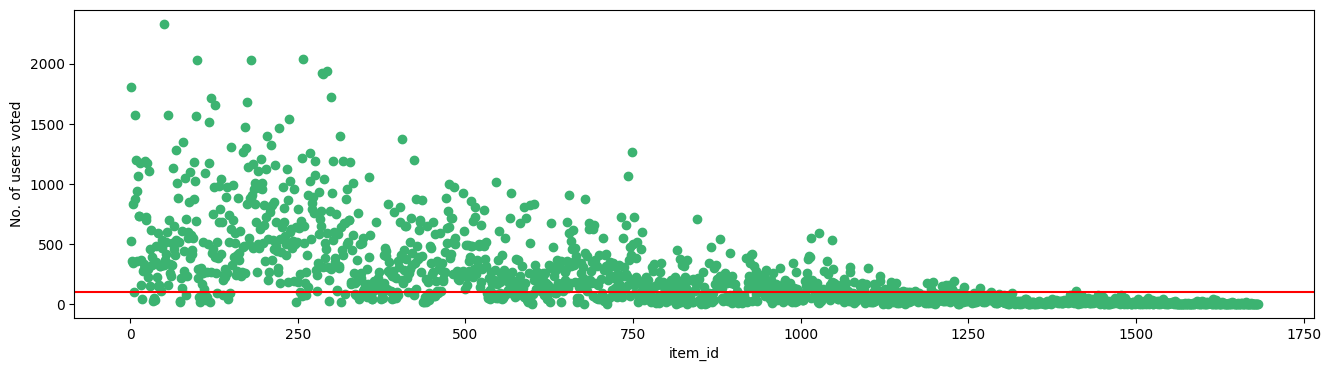

In [29]:
no_user_voted = df.groupby('item_id')['rating'].agg('count')
no_movies_voted = df.groupby('user_id')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=100,color='r')
plt.xlabel('item_id')
plt.ylabel('No. of users voted')
plt.show()

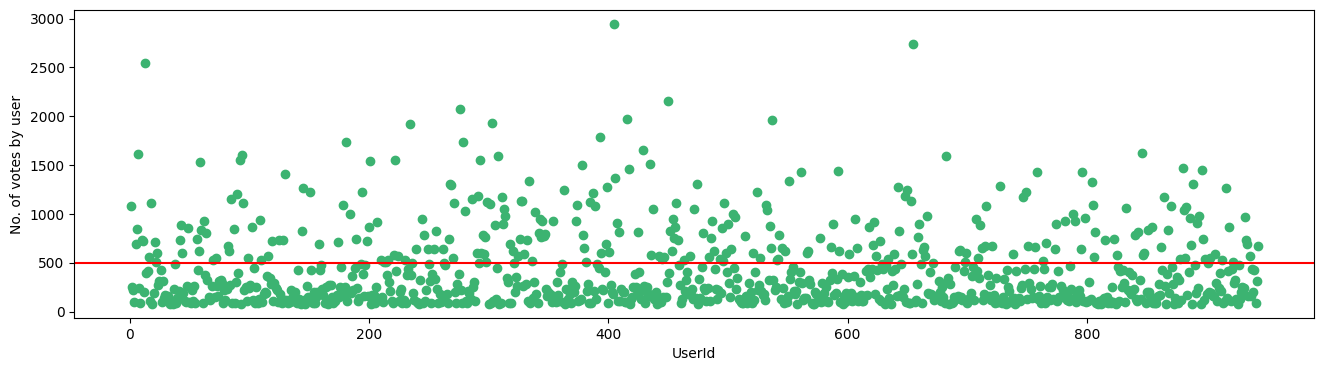

In [30]:
filtered_user_ids = no_user_voted[no_user_voted > 100].index
final_dataset = df[df.index.isin(filtered_user_ids)]

f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=500,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [31]:
final_dataset

,user_id,item_id,rating,movie_title,unknown,Action,Adventure,Animation,Children's,Comedy,...,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code,day_of_week
1,1,1,5,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,24,1,19,622,6
2,1,1,5,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,24,1,19,622,6
3,1,1,5,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,24,1,19,622,6
4,1,2,3,GoldenEye (1995),0,1,1,0,0,0,...,0,0,1,0,0,24,1,19,622,6
5,1,2,3,GoldenEye (1995),0,1,1,0,0,0,...,0,0,1,0,0,24,1,19,622,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,2,302,5,L.A. Confidential (1997),0,0,0,0,0,0,...,0,0,1,0,0,53,0,13,689,2
1244,2,304,4,Fly Away Home (1996),0,0,1,0,1,0,...,0,0,0,0,0,53,0,13,689,4
1267,2,311,5,"Wings of the Dove, The (1997)",0,0,0,0,0,0,...,1,0,1,0,0,53,0,13,689,2
1284,2,290,3,Fierce Creatures (1997),0,0,0,0,0,1,...,0,0,0,0,0,53,0,13,689,4


In [32]:
movie_label = LabelEncoder()

final_dataset['movie_title'] = movie_label.fit_transform(final_dataset['movie_title'])

csr_data = csr_matrix(final_dataset.values)

final_dataset.reset_index(inplace=True)

<ipython-input-32-55e16d7edd05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['movie_title'] = movie_label.fit_transform(final_dataset['movie_title'])


In [33]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [34]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [35]:
def get_movie_recommendation(movie_name, n_movies_to_reccomend):
    n_movies_to_reccomend = n_movies_to_reccomend * 2
    movie_name = movie_label.transform([movie_name])
    movie_list = final_dataset[final_dataset['movie_title'] == movie_name[0]]
    if len(movie_list):
        movie_idx= movie_list.iloc[0]['item_id']
        movie_idx = final_dataset[final_dataset['item_id'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]

        for val in rec_movie_indices[::-2]:
            movie_idx = final_dataset.iloc[val[0]]['item_id']
            idx = final_dataset[final_dataset['item_id'] == movie_idx].index
            movie_title_inversed = movie_label.inverse_transform([final_dataset.iloc[idx]['movie_title'].values[0]])[0]
            print(f'movie_title: "{movie_title_inversed}", Distance:"{val[1]}"')
    else:
        return "No movies found. Please check your input"

In [36]:
get_movie_recommendation('Copycat (1995)', 10)

movie_title: "Copycat (1995)", Distance:"0.0"
movie_title: "Dead Man Walking (1995)", Distance:"9.006312116988102e-05"
movie_title: "Dead Man Walking (1995)", Distance:"9.006312116988102e-05"
movie_title: "Brothers McMullen, The (1995)", Distance:"0.0007241806519611149"
movie_title: "Brothers McMullen, The (1995)", Distance:"0.0007241806519611149"
movie_title: "Braveheart (1995)", Distance:"0.0007955899575010639"
movie_title: "Braveheart (1995)", Distance:"0.0007955899575010639"
movie_title: "Crimson Tide (1995)", Distance:"0.0008664069890714776"
movie_title: "Crimson Tide (1995)", Distance:"0.0008664069890714776"
movie_title: "Crumb (1994)", Distance:"0.0009523355757610208"


In [37]:
get_movie_recommendation('Toy Story (1995)', 5)

movie_title: "Toy Story (1995)", Distance:"0.0"
movie_title: "Twelve Monkeys (1995)", Distance:"6.148219760648832e-05"
movie_title: "Twelve Monkeys (1995)", Distance:"6.148219760648832e-05"
movie_title: "Usual Suspects, The (1995)", Distance:"0.00027185227882431384"
movie_title: "Usual Suspects, The (1995)", Distance:"0.00027185227882431384"
